<a href="https://colab.research.google.com/github/ach224/Prediction_eligibilite_pret_bancaire/blob/Optimisation_A%C3%AFcha/Optimisation_A%C3%AFcha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Etape 4 : Optimisation

## Récupération du dataframe
Nous gardons comme modèle principale pour cette phase le random forest, étant donnée qu'il avait les meilleurs métriques lors de la phase de modélisation.

In [15]:
# 0. Imports
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Chargement du dataset brut
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/DATA SCIENCES/PROJET DATA SCIENCES/loan_prediction.csv")
print(df.shape)
df.head()

# 2. Nettoyage & préparation
# a) Suppression de l'identifiant (non utile pour la prédiction)
df = df.drop(columns=["Loan_ID"])
# b) Imputation des valeurs manquantes
colonnes_cat = ["Gender", "Married", "Dependents", "Education",
                "Self_Employed", "Property_Area", "Loan_Status"]
colonnes_num = ["ApplicantIncome", "CoapplicantIncome",
                "LoanAmount", "Loan_Amount_Term", "Credit_History"]
# Catégorielles -> valeur la plus fréquente (mode)
for col in colonnes_cat:
    df[col] = df[col].fillna(df[col].mode()[0])
# Numériques -> médiane
for col in colonnes_num:
    df[col] = df[col].fillna(df[col].median())

# 3. Encodage des variables
# Encodage binaire (comme dans ton premier notebook)
df["Gender"]        = df["Gender"].map({"Male": 0, "Female": 1})
df["Married"]       = df["Married"].map({"No": 0, "Yes": 1})
df["Education"]     = df["Education"].map({"Not Graduate": 0, "Graduate": 1})
df["Self_Employed"] = df["Self_Employed"].map({"No": 0, "Yes": 1})
df["Credit_History"]= df["Credit_History"].astype(int)  # déjà 0/1
df["Loan_Status"]   = df["Loan_Status"].map({"N": 0, "Y": 1})
# Dependents : on remplace "3+" par 3 et on passe en int
df["Dependents"] = df["Dependents"].replace("3+", 3).astype(int)
# Property_Area : encodage simple 0/1/2
df["Property_Area"] = df["Property_Area"].map({"Rural": 0, "Semiurban": 1, "Urban": 2})
# Conversion en int des colonnes appropriées
cols_int = ["Gender", "Married", "Dependents", "Education",
            "Self_Employed", "Credit_History", "Property_Area", "Loan_Status"]
df[cols_int] = df[cols_int].astype(int)
df.info()
print(df)

# 4. Séparation features / cible
X = df.drop(columns=["Loan_Status"])
y = df["Loan_Status"]

# 5. Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)

# 6. Modélisation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# Random Forest avant optimisation
rf_base = RandomForestClassifier(random_state=42,)
rf_base.fit(X_train, y_train)
y_pred_base  = rf_base.predict(X_test)
y_proba_base = rf_base.predict_proba(X_test)[:, 1]
RF_before_opt = pd.DataFrame([{
    "Modèle":   "Random Forest (avant optimisation)",
    "Accuracy":  accuracy_score(y_test, y_pred_base),
    "Precision": precision_score(y_test, y_pred_base),
    "Recall":    recall_score(y_test, y_pred_base),
    "F1-score":  f1_score(y_test, y_pred_base),
    "ROC-AUC":   roc_auc_score(y_test, y_proba_base),
}])
display(RF_before_opt.round(3))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(614, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    int64  
 1   Married            614 non-null    int64  
 2   Dependents         614 non-null    int64  
 3   Education          614 non-null    int64  
 4   Self_Employed      614 non-null    int64  
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    int64  
 10  Property_Area      614 non-null    int64  
 11  Loan_Status        614 non-null    int64  
dtypes: float64(3), int64(9)
memory usage: 57.7 KB
     Gender  Married  Dependents 

,Modèle,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,Random Forest (avant optimisation),0.829,0.848,0.918,0.881,0.789


Après avoir récupérer tous les codes précents, on peut passer à l'étape de modélisation concrètes.

## Etape 1 : Feature engineering
Le feature engineering consiste à créer une ou plusieurs nouvelles variables à partir de celle déjà existantes, dans le but d'améliorer la prédiction du modèle.


Une nouvelle variable pertinente serait `Income-to-Loan-Ratio`.

Cette variable représente la **capacité réelle de remboursement du demandeur** : plus ce ratio est élevé, plus l’emprunteur a des revenus proportionnellement supérieurs au montant demandé → plus il est solvable.

Formule :
$$
\text{Income-to-Loan-Ratio} = \frac{ApplicantIncome + CoapplicantIncome}{LoanAmount}
$$



In [16]:
# Création de la variable Income-to-Loan-Ratio
df["Income-to-Loan-Ratio"] = (df["ApplicantIncome"] + df["CoapplicantIncome"]) / df["LoanAmount"]
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Income-to-Loan-Ratio
0,0,0,0,1,0,5849,0.0,128.0,360.0,1,2,1,45.695312
1,0,1,1,1,0,4583,1508.0,128.0,360.0,1,0,0,47.585938
2,0,1,0,1,1,3000,0.0,66.0,360.0,1,2,1,45.454545
3,0,1,0,0,0,2583,2358.0,120.0,360.0,1,2,1,41.175000
4,0,0,0,1,0,6000,0.0,141.0,360.0,1,2,1,42.553191


In [17]:
# Nouvelle modélisation
X = df.drop(columns=["Loan_Status"])
y = df["Loan_Status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

from sklearn.ensemble import RandomForestClassifier
rf_after_fe = RandomForestClassifier(random_state=42)
rf_after_fe.fit(X_train, y_train)

y_pred_after_fe = rf_after_fe.predict(X_test)
y_proba_after_fe = rf_after_fe.predict_proba(X_test)[:,1]

RF_after_fe = pd.DataFrame([{
    "Modèle":   "Random Forest (après Feature Engineering)",
    "Accuracy":  accuracy_score(y_test, y_pred_after_fe),
    "Precision": precision_score(y_test, y_pred_after_fe),
    "Recall":    recall_score(y_test, y_pred_after_fe),
    "F1-score":  f1_score(y_test, y_pred_after_fe),
    "ROC-AUC":   roc_auc_score(y_test, y_proba_after_fe),
}])

RF_compare = pd.concat([RF_before_opt, RF_after_fe], ignore_index=True)
display(RF_compare)



,Modèle,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,Random Forest (avant optimisation),0.829268,0.847826,0.917647,0.881356,0.788854
1,Random Forest (après Feature Engineering),0.861789,0.869565,0.941176,0.903955,0.862848


On constate une amélioration des métriques :

✔️ +3.2 points d’accuracy

✔️ +1.7 points en precision

✔️ +2.4 points en recall

✔️ +2.2 points en **F1-score**

✔️ +7.4 points en **ROC-AUC**

Ces résultats démontrent que notre nouvelle variable permet une meilleure prédiction. Néanmoins, il est possible d'aller plus loin.

## Etape 2 : Hyperparameter tuning


### A. RandomizedSearchCV

In [18]:
from sklearn.model_selection import RandomizedSearchCV

# Modèle de base
rf = RandomForestClassifier(random_state=42)

# Espace de recherche des hyperparamètres
param_dist = {
    "n_estimators":      [100, 200, 300, 400, 500],
    "max_depth":         [None, 3, 5, 7, 9, 12],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf":  [1, 2, 4],
    "max_features":      ["sqrt", "log2", 0.5],
    "class_weight":      [None, "balanced"]
}

# RandomizedSearchCV : on optimise le F1-score (classe positive = 1)
rf_random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,              # nombre de combinaisons testées
    scoring="f1",           # on optimise le F1-score
    cv=5,                   # validation croisée 5-fold
    n_jobs=-1,              # utilise tous les coeurs dispo
    random_state=42,
    verbose=1
)

rf_random_search.fit(X_train, y_train)

print("Meilleurs hyperparamètres trouvés :")
rf_random_search.best_params_, rf_random_search.best_score_


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Meilleurs hyperparamètres trouvés :


({'n_estimators': 300,
  'min_samples_split': 10,
  'min_samples_leaf': 2,
  'max_features': 'sqrt',
  'max_depth': 9,
  'class_weight': None},
 np.float64(0.8704939614537139))

In [19]:
rf_after_rsCV = rf_random_search.best_estimator_
rf_after_rsCV.fit(X_train, y_train)

y_pred_after_rsCV  = rf_after_rsCV.predict(X_test)
y_proba_after_rsCV = rf_after_rsCV.predict_proba(X_test)[:, 1]

RF_after_rsCV = pd.DataFrame([{
    "Modèle":   "Random Forest (après RandomisedSearchCV)",
    "Accuracy":  accuracy_score(y_test, y_pred_after_rsCV),
    "Precision": precision_score(y_test, y_pred_after_rsCV),
    "Recall":    recall_score(y_test, y_pred_after_rsCV),
    "F1-score":  f1_score(y_test, y_pred_after_rsCV),
    "ROC-AUC":   roc_auc_score(y_test, y_proba_after_rsCV),
}])

RF_compare = pd.concat([RF_before_opt, RF_after_fe, RF_after_rsCV])
display(RF_compare)

,Modèle,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,Random Forest (avant optimisation),0.829268,0.847826,0.917647,0.881356,0.788854
0,Random Forest (après Feature Engineering),0.861789,0.869565,0.941176,0.903955,0.862848
0,Random Forest (après RandomisedSearchCV),0.869919,0.848485,0.988235,0.913043,0.859443


Le réglage des hyperparamètres par la méthode RandomizedSearchCV ne change pas fondamentalement le modèle, mais ajuste :
* profondeur des arbres
* nombre d’arbres
* nombre minimal d’échantillons par split
* class_weight
* max_features

➡️ Ça améliore surtout la *Recall* et le *F1-score*.

# Conclusion

Il n'y a pas besoin d'équilibrer les classes étant donné que l'étape du réglage des hyperparamètres nous indique que `class_weight : None`

Voici plusieurs observations de nos métriques avant et après optimisation :

In [21]:
RF_after_rsCV["Modèle"] = "Random Forest (après optimisation)"
RF_after_opt = RF_after_rsCV
RF_compare = pd.concat([RF_before_opt, RF_after_opt])
display(RF_compare.round(2))

,Modèle,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,Random Forest (avant optimisation),0.83,0.85,0.92,0.88,0.79
0,Random Forest (après optimisation),0.87,0.85,0.99,0.91,0.86


On observe une augmentation très significative de nos métriques les plus importantes, que sont le **recall**, le **F1-score** et le **ROC-AUC**.

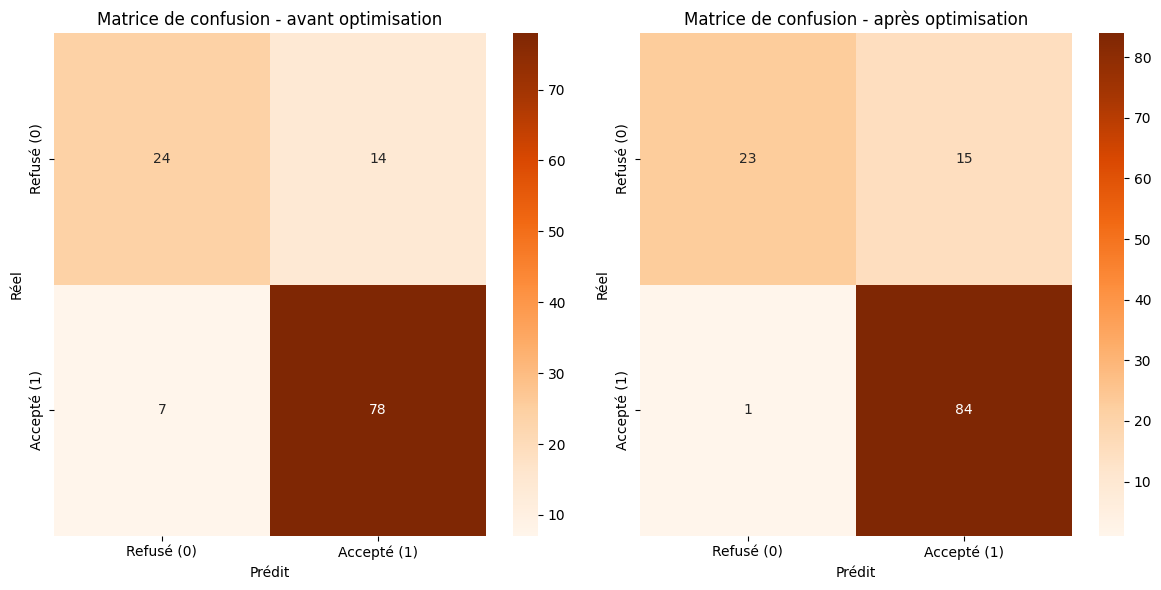

In [30]:
# Comparaison des matrices de confusion
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test, y_pred_base)
cm2 = confusion_matrix(y_test, y_pred_after_rsCV)

# fig = plt.figure(figsize=(12, 6)).subplots(1,2)
fig, axes = plt.subplots(1,2, figsize = (12,6))
sns.heatmap(cm1, ax = axes[0], annot=True, cmap="Oranges", xticklabels=["Refusé (0)", "Accepté (1)"], yticklabels=["Refusé (0)", "Accepté (1)"])
axes[0].set_title("Matrice de confusion - avant optimisation")
axes[0].set_xlabel("Prédit")
axes[0].set_ylabel("Réel")

sns.heatmap(cm2, ax = axes[1], annot=True, cmap="Oranges", xticklabels=["Refusé (0)", "Accepté (1)"], yticklabels=["Refusé (0)", "Accepté (1)"])
axes[1].set_title("Matrice de confusion - après optimisation")
axes[1].set_xlabel("Prédit")
axes[1].set_ylabel("Réel")

plt.tight_layout()
plt.show()